In [51]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
import sys
from pylab import *
import os
import urllib.request
import itertools
import seaborn as sns
import numpy as np
from adjustText import adjust_text

In [52]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

pd.options.mode.chained_assignment = None

In [53]:
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

In [54]:
YEAR = 2020
data = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_' + str(YEAR) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False)

In [55]:
#remove deprecated columns
data.drop(['passer_player_name', 'passer_player_id',
           'rusher_player_name', 'rusher_player_id',
           'receiver_player_name', 'receiver_player_id'],
          axis=1, inplace=True)

In [56]:
#remove plays that are not penalties, passes, or runs or have null epa
data = data.loc[(data.play_type.isin(['no_play','pass','run'])) & (data.epa.isna()==False)]

In [57]:
#make sure QB scrambles are labeled appropriately
data.play_type.loc[data['pass']==1] = 'pass'
data.play_type.loc[data.rush==1] = 'run'

In [58]:
#clean up index after data clean up
data.reset_index(drop=True, inplace=True)

In [59]:
#group by without making it the index!
recs = data.loc[data['play_type']=='pass'].groupby(['receiver', 'posteam'], as_index=False).agg({'epa':'sum',
                                                               'cpoe':'sum',
                                                               'air_yards':'sum',
                                                                'pass_attempt':'count'})

In [60]:
recs['cpoe/p'] = recs.cpoe/recs.pass_attempt
recs['epa/p'] = recs.epa/recs.pass_attempt
recs['airyards/p'] = recs.air_yards/recs.pass_attempt
recs = recs.loc[(recs['pass_attempt'] > 90)]
#recs

In [61]:
recs.sort_values('epa', ascending=False, inplace=True)

In [62]:
#round data!
recs = recs.round(2)

#rename columns easily!
recs.columns = ['Player', 'Team', 'Total EPA', 'Total CPOE', 'Total Air Yards', 'Targets', 'CPOE per Target', 'EPA per Target', 'aDOT']

In [64]:
#Add team colors to dataframe
#maps using Team abbrev matching dict key
recs['color'] = recs['Team'].map(COLORS)
#recs

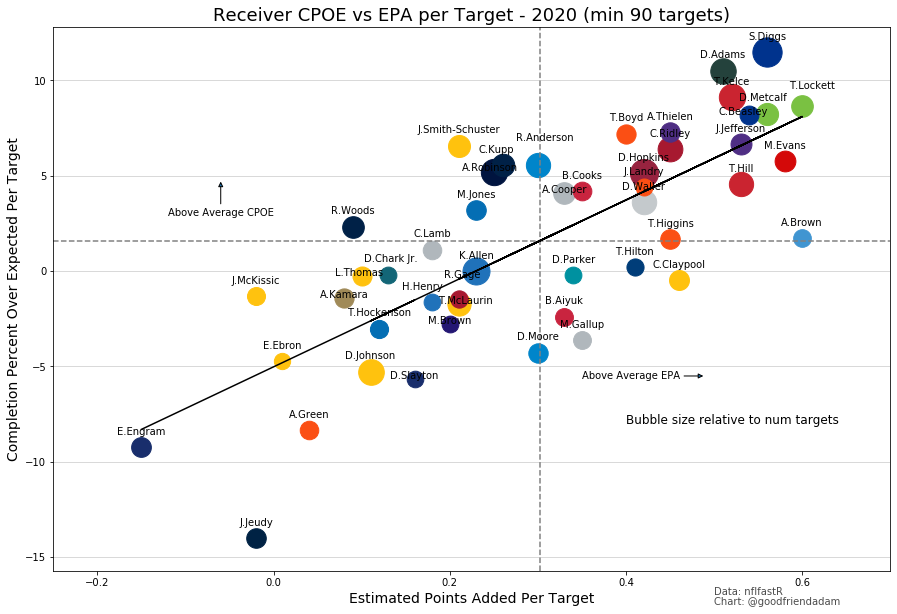

In [101]:
#create figure
fig, ax = plt.subplots(figsize=(15,10))

#make scatter plot with data

#add data to chart
for player, row in recs.iterrows():
    plt.scatter(row['EPA per Target'], row['CPOE per Target'], label=player, c=row['color'],
                s=(row['Targets'])*(row['Targets'])*.03)
#    plt.text(row['CPOE']-0.3, row['EPA per Dropback']+.01, row['Player'])
    #plt.text(x0, y0, frameon=False, fontsize=4)

#append names and allows to adjust below
texts = []
for x, y, s in zip(recs['EPA per Target'], recs['CPOE per Target'], recs['Player']):
    texts.append(plt.text(x, y+.5, s))
    
#add grid
ax.grid(zorder=0, alpha=.6, axis='y')
ax.set_axisbelow(True)

#set average cpoe
ax.axvline(x=recs['EPA per Target'].mean(), linestyle='--', color='grey')

#set average epa
ax.axhline(y=recs['CPOE per Target'].mean(), linestyle='--', color='grey')

# Calculate the simple average of the data
epa_mean = [np.mean(recs['EPA per Target'])]
cpoe_mean = [np.mean(recs['CPOE per Target'])]

#plot fit line
pfit = np.polyfit(recs['EPA per Target'], recs['CPOE per Target'], 1)
trend_line_model = np.poly1d(pfit)
plt.plot(recs['EPA per Target'], trend_line_model(recs['EPA per Target']), linestyle="-", c='black') 

# Plot the average line
#plt.plot(cpoe_mean,epa_mean, 'k-', label='Mean')

ax.annotate('Above Average CPOE', xy=(-0.06, 4.8), xytext=(-0.06, 2.9),
            arrowprops={'arrowstyle': '-|>'}, ha='center', color='black', fontsize=10)

#League average line label for epa
ax.annotate('Above Average EPA', xy=(0.49, -5.5), xytext=(0.35, -5.5),
            arrowprops={'arrowstyle': '-|>'},  va='center', color='black', fontsize=10)

#add labels and text
ax.set_xlabel('Estimated Points Added Per Target', fontsize=14)
ax.set_ylabel('Completion Percent Over Expected Per Target', fontsize=14)
ax.set_title('Receiver CPOE vs EPA per Target - 2020 (min 90 targets)', fontsize=18)
ax.text(0.4, -8, 'Bubble size relative to num targets', fontsize=12, color='black')
ax.text(0.5, -17.5, 'Chart: @goodfriendadam', fontsize=10, alpha=.7)
ax.text(0.5, -17, 'Data: nflfastR', fontsize=10, alpha=.7)
#plt.legend()

ax.set_xlim(-.25, .7)
#adjust name spacing so no overlaps
adjust_text(texts, autoalign='y',
            only_move={'points':'y', 'text':'xy'})#, arrowprops=dict(arrowstyle='fancy', color='black'))

plt.savefig(os.getcwd() + '\\output\\recepacpoe2020.png',dpi=400)

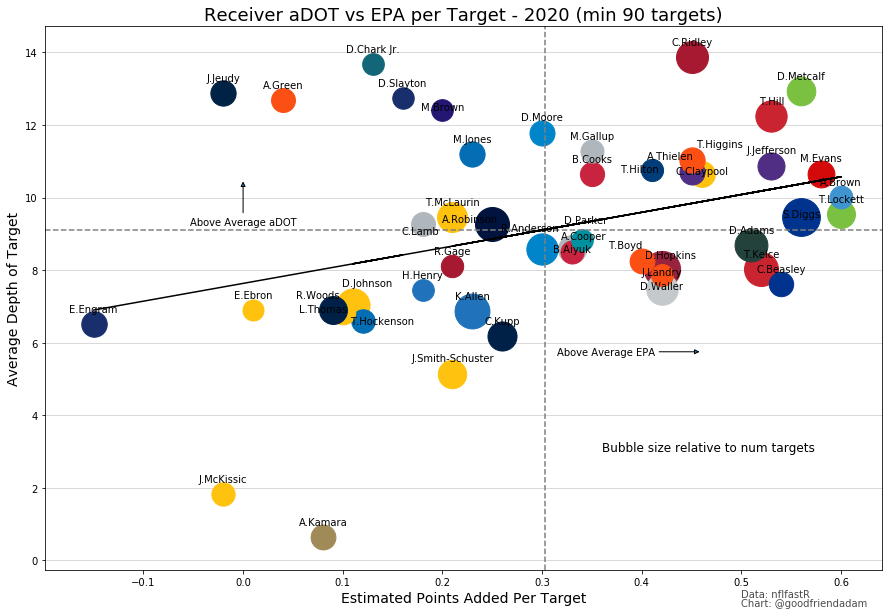

In [100]:
#create figure
fig, ax = plt.subplots(figsize=(15,10))


#make scatter plot with data - alternate?
#x = reccpoe['epa/p']
#y = reccpoe['airyards/p']
#c = sns.color_palette(None, len(reccpoe.index))
#s = (reccpoe['pass_attempt'])*(reccpoe['pass_attempt'])*.08
#scatter = ax.scatter(x, y, c=c, s=s)

#make scatter plot with data
#add data to chart
for player, row in recs.iterrows():
    scatter = plt.scatter(row['EPA per Target'], row['aDOT'], label=player, c=row['color'], 
                          s=(row['Targets'])*(row['Targets'])*.05)
    #for diff size dots-> s=(row['pass_attempt'])*(row['pass_attempt'])*.5)
    #plt.text(row['epa/p']-.0235, row['airyards/p']+.3, player)
    #plt.text(x0, y0, frameon=False, fontsize=4)

#append names and allows to adjust below
texts = []
for x, y, s in zip(recs['EPA per Target'], recs['aDOT'], recs['Player']):
    texts.append(plt.text(x#-.018
                          , y+.25, s))

#add grid
ax.grid(zorder=0, alpha=.6, axis='y')
ax.set_axisbelow(True)

#set average cpoe
ax.axhline(y=recs['aDOT'].mean(), linestyle='--', color='grey')

#set average epa
ax.axvline(x=recs['EPA per Target'].mean(), linestyle='--', color='grey')

ax.annotate('Above Average aDOT', xy=(0.0, 10.5), xytext=(0.0, 9.25),
            arrowprops={'arrowstyle': '-|>'}, ha='center', color='black', fontsize=10)

#League average line label for epa
ax.annotate('Above Average EPA', xy=(0.46, 5.75), xytext=(0.315, 5.75),
            arrowprops={'arrowstyle': '-|>'},  va='center', color='black', fontsize=10)

#plot fit line
pfit = np.polyfit(recs['EPA per Target'], recs['aDOT'], 1)
trend_line_model = np.poly1d(pfit)
plt.plot(recs['EPA per Target'], trend_line_model(recs['EPA per Target']), linestyle="-", c='black') 

#add labels and text
ax.set_xlabel('Estimated Points Added Per Target', fontsize=14)
ax.set_ylabel('Average Depth of Target', fontsize=14)
ax.set_title('Receiver aDOT vs EPA per Target - 2020 (min 90 targets)', fontsize=18)
ax.text(0.36, 3, 'Bubble size relative to num targets', fontsize=12, color='black')
ax.text(0.5, -1.25, 'Chart: @goodfriendadam', fontsize=10, alpha=.7)
ax.text(0.5, -1, 'Data: nflfastR', fontsize=10, alpha=.7)
#plt.legend()

#adjust name spacing so no overlaps
adjust_text(texts, autoalign='y',
            only_move={'points':'y', 'text':'xy'})#, arrowprops=dict(arrowstyle='fancy', color='black'))

plt.savefig(os.getcwd() + '\\output\\recaDOTepa2020.png',dpi=400)

In [14]:
#cols = data.columns.tolist()
#cols